In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
from scipy.stats import pearsonr
import msprime as msp


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
class TwoLocusTheoryConstant:
    """Theoretical two-locus properties in a model of population-continuity."""

    def _eTATB(rho, ta):
        u200 = lambda rho: (rho ** 2 + 14 * rho + 36) / (
            rho ** 2 + 13 * rho + 18
        )  # noqa
        u111 = lambda rho: (rho ** 2 + 13 * rho + 24) / (
            rho ** 2 + 13 * rho + 18
        )  # noqa
        # Calculate the probability of uncoupling of the ancient haplotype
        p111 = lambda r, t: r * (1.0 - np.exp(-t * (r / 2 + 1))) / (r + 2)  # noqa
        return p111(rho, ta) * u111(rho) + (1 - p111(rho, ta)) * u200(rho)

    def _eTATB_appx(rho, ta):
        u200 = lambda rho: (rho ** 2 + 14 * rho + 36) / (
            rho ** 2 + 13 * rho + 18
        )  # noqa
        u111 = lambda rho: (rho ** 2 + 13 * rho + 24) / (
            rho ** 2 + 13 * rho + 18
        )  # noqa
        # Calculate the probability of uncoupling of the ancient haplotype
        p111_appx = lambda r, t: (t * r) / 2  # noqa
        return p111_appx(rho, ta) * u111(rho) + (1 - p111_appx(rho, ta)) * u200(rho)

    def _corrLALB(rho, ta):
        return TwoLocusTheoryConstant._eTATB(rho, ta) - 1.0

    def _corrLALB_appx(rho, ta):
        return TwoLocusTheoryConstant._eTATB_appx(rho, ta) - 1.0

    def _covLALB(rho, ta):
        return 4 * (TwoLocusTheoryConstant._corrLALB(rho, ta))
    
    def _covSASB(rho, ta, theta=1.0):
        return (theta**2)/4. *(TwoLocusTheoryConstant._covLALB(rho, ta))
    
    def _corrSASB(rho, ta, theta=1.0):
        """Correlation in segregating sites."""
        corrSASB = (
            1.0
            / (1.0 + (2.0 + ta) / (2 * theta))
            * TwoLocusTheoryConstant._corrLALB(rho, ta)
        )
        return corrSASB

In [3]:
e_SA = lambda theta: theta

var_SA = lambda theta: theta + theta**2

# Eq. 4.14 from Wakeley et al...
var_pi = lambda n,theta: (n+1)/(3*(n-1))*theta + 2*(n**2 + n + 3) / (9*n*(n-1))*(theta**2)

def pair_bl(ts_reps, nreps, **kwargs):
    pair_branch_length = np.zeros(shape=(nreps, 2))
    i = 0
    for ts in ts_reps:
        # NOTE : using the tskit approach here because it is coded in c
        cur_bl = ts.segregating_sites(**kwargs)
        cur_bl = np.tile(cur_bl, 2)
        pair_branch_length[i] = cur_bl[:2]
        i += 1
    return(pair_branch_length)

def pair_mut(ts_reps, nreps, **kwargs):
    pair_muts = np.zeros(shape=(nreps, 2))
    i = 0
    for ts in ts_reps:
        cur_muts = ts.segregating_sites(**kwargs)
        cur_muts = np.tile(cur_muts, 2)
        pair_muts[i] = cur_muts[:2]
        i += 1
    return(pair_muts)    

# Tracking Joint and Marginal Genealogical and Mutational Properties

## The case of $\theta = 0.4$ (The good version)

50it [00:12,  3.86it/s]


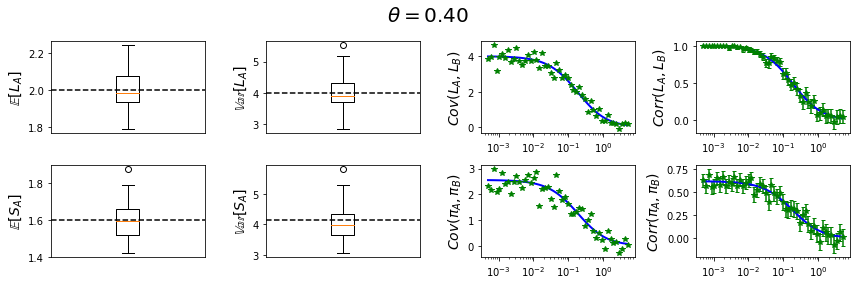

In [4]:

# simulate under both of these maps
nreps = 500
theta = 0.4
Ne = 1.0
rs = np.logspace(-3, np.log10(10), 50)
corr_bl = np.zeros(rs.size)
cov_bl = np.zeros(rs.size)
e_bl = np.zeros(rs.size)
var_bl = np.zeros(rs.size)
corr_mut = np.zeros(rs.size)
cov_mut = np.zeros(rs.size)
e_mut = np.zeros(rs.size)
var_mut = np.zeros(rs.size)

for i,r in tqdm(enumerate(rs)):
    
    recomb_map1 = msp.RecombinationMap.uniform_map(2, r/2, num_loci=2)
    ts1 = msp.simulate(Ne=1.0, sample_size=2, mutation_rate=theta,
                       recombination_map=recomb_map1, num_replicates=nreps, random_seed=i+1)

    bl1 = pair_bl(ts1, nreps, mode="branch", windows="trees")
    bl1 = bl1 / (2. * 1.0)

    corr_bl[i] = pearsonr(bl1[:,0], bl1[:,1])[0]
    cov_bl[i] = np.cov(bl1[:,0], bl1[:,1])[0,1]
    var_bl[i] = np.var(bl1[:,0])
    e_bl[i] = np.mean(bl1[:,0])
    ts2 = msp.simulate(Ne=1.0, sample_size=2, mutation_rate=theta,
                       recombination_map=recomb_map1, num_replicates=nreps, random_seed=i+1)
    m = pair_mut(ts2, nreps, mode="site", windows=[0.,1.,2.], span_normalise=False)
    e_mut[i] = np.mean(m[:,0])
    var_mut[i] = np.var(m[:,0])
    cov_mut[i] = np.cov(m[:,0], m[:,1])[0,1]
    corr_mut[i] = pearsonr(m[:,0], m[:,1])[0]
    
    
# Standard errors for correlation (asymptotic)
se_r_bl = np.sqrt((1. - (corr_bl**2))/(nreps-2))
se_r_mut = np.sqrt((1. - (corr_mut**2))/(nreps-2))

fig, ax = plt.subplots(2,4, figsize=(12,4))
# Top Row : branch based moments (joint and marginal)
ax[0,0].boxplot(e_bl)
ax[0,0].set_ylabel(r'$\mathbb{E}[L_A]$', fontsize=14)
ax[0,0].axhline(2.0, linestyle='--', color='black')
ax[0,0].set_xticks([])

ax[0,1].boxplot(var_bl)
ax[0,1].set_ylabel(r'$\mathbb{Var}[L_A]$', fontsize=14)
ax[0,1].axhline(4.0, linestyle='--', color='black')
ax[0,1].set_xticks([])

ax[0,2].errorbar(rs/2, cov_bl, capsize=2, color='green', fmt='*')
ax[0,2].set_ylabel(r'$Cov(L_A,L_B)$', fontsize=14)
ax[0,2].plot(rs/2, TwoLocusTheoryConstant._covLALB(4*rs, ta=0.), 
           color='blue', lw=2)
ax[0,2].set_xscale('log')

ax[0,3].errorbar(rs/2, corr_bl, yerr=2*se_r_bl, capsize=2, 
                 color='green', fmt='*')
ax[0,3].set_ylabel(r'$Corr(L_A,L_B)$', fontsize=14)
ax[0,3].plot(rs/2, TwoLocusTheoryConstant._corrLALB(4*rs, ta=0.),
           color='blue', lw=2)
ax[0,3].set_xscale('log')

# Bottom Row: mutation based statistics
ax[1,0].boxplot(e_mut)
ax[1,0].set_ylabel(r'$\mathbb{E}[S_A]$', fontsize=14)
ax[1,0].axhline(e_SA(4*theta), linestyle='--', color='black')
ax[1,0].set_xticks([])
ax[1,1].boxplot(var_mut)
ax[1,1].set_ylabel(r'$\mathbb{Var}[S_A]$', fontsize=14)
ax[1,1].axhline(var_SA(4*theta), linestyle='--', color='black')
ax[1,1].set_xticks([])

ax[1,2].errorbar(rs/2, cov_mut, capsize=2, color='green', fmt='*')
ax[1,2].plot(rs/2, TwoLocusTheoryConstant._covSASB(4*rs, theta=4*theta, ta=0.), 
        color='blue', lw=2)
ax[1,2].set_ylabel(r'$Cov(\pi_A,\pi_B)$', fontsize=14)
ax[1,2].set_xscale('log')

ax[1,3].errorbar(rs/2, corr_mut, yerr=2*se_r_mut, capsize=2, 
                 color='green', fmt='*')
ax[1,3].set_ylabel(r'$Corr(\pi_A,\pi_B)$', fontsize=14)
ax[1,3].plot(rs/2, TwoLocusTheoryConstant._corrSASB(4*rs, theta=4*theta, ta=0.), 
        color='blue', lw=2)
ax[1,3].set_xscale('log')

plt.suptitle(r'$\theta = %0.2f$' % theta, fontsize=20)
plt.tight_layout()
# plt.savefig('moment_matching_test_theta_4_1kb.pdf', bbox_inches='tight')